# Aprendizado de Máquina em Séries Temporais
## Sea Surface Temperature Forecasting

- Gildo
- Maiser
- Victal
- Vítor Fróis: 12543440

# Imports

In [1]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import numpy as np
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import matplotlib.pyplot as plt
import pandas as pd
from dtw import *
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# fp = 'data/sst.mon.ltm.1991-2020.nc'
fp = 'data/sst.mnmean.nc'
ds = nc.Dataset(fp)
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    climatology: Climatology is based on 1971-2000 SST, Xue, Y., T. M. Smith, and R. W. Reynolds, 2003: Interdecadal changes of 30-yr SST normals during 1871.2000. Journal of Climate, 16, 1601-1612.
    description: In situ data: ICOADS2.5 before 2007 and NCEP in situ data from 2008 to present. Ice data: HadISST ice before 2010 and NCEP ice after 2010.
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Science Keywords
    keywords: Earth Science > Oceans > Ocean Temperature > Sea Surface Temperature >
    instrument: Conventional thermometers
    source_comment: SSTs were observed by conventional thermometers in Buckets (insulated or un-insulated canvas and wooded buckets) or Engine Room Intaker
    geospatial_lon_min: -1.0
    geospatial_lon_max: 359.0
    geospatial_laty_max: 89.0
    geospatial_laty_min: -89.0
    geospatial_lat_max: 89.0
    geospatial_lat_min: -89.0
    

# Análise do Dataset
Vamos trabalhar com dados que possuem uma séries temporal para áreas do oceano com 2° de lado 

In [3]:
ds.variables.keys()

dict_keys(['lat', 'lon', 'time_bnds', 'time', 'sst'])

In [4]:
ds.variables['sst'].long_name

'Monthly Means of Sea Surface Temperature'

In [5]:
ds.variables['time_bnds'].long_name

'Time Boundaries'

In [6]:
ds.variables['time']

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: days since 1800-1-1 00:00:00
    long_name: Time
    delta_t: 0000-01-00 00:00:00
    avg_period: 0000-01-00 00:00:00
    prev_avg_period: 0000-00-07 00:00:00
    standard_name: time
    axis: T
    actual_range: [19723. 81722.]
unlimited dimensions: time
current shape = (2038,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [7]:
ds['sst'][200,10,10]

masked

# Transformando em Dataframe

In [45]:
ds = xr.open_dataset(fp)
df = ds.to_dataframe()

In [46]:
df.head()

time_bnds  sst
lat  lon time       nbnds                   
88.0 0.0 1854-01-01 0      9.969210e+36 -1.8
                    1      9.969210e+36 -1.8
         1854-02-01 0      9.969210e+36 -1.8
                    1      9.969210e+36 -1.8
         1854-03-01 0      9.969210e+36 -1.8

In [47]:
df = df.reset_index()
df = df[df['nbnds'] == 0] # Garante que há apenas uma medição por área por tempo
df.head()

,lat,lon,time,nbnds,time_bnds,sst
0,88.0,0.0,1854-01-01,0,9.969210e+36,-1.8
2,88.0,0.0,1854-02-01,0,9.969210e+36,-1.8
4,88.0,0.0,1854-03-01,0,9.969210e+36,-1.8
6,88.0,0.0,1854-04-01,0,9.969210e+36,-1.8
8,88.0,0.0,1854-05-01,0,9.969210e+36,-1.8


In [11]:
df.shape

(32648760, 6)

In [12]:
ds.variables['sst']

<xarray.Variable (time: 2038, lat: 89, lon: 180)>
array([[[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ...,

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]], dtype=float32)
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [13]:
df['lat'].unique()

array([ 88.,  86.,  84.,  82.,  80.,  78.,  76.,  74.,  72.,  70.,  68.,
        66.,  64.,  62.,  60.,  58.,  56.,  54.,  52.,  50.,  48.,  46.,
        44.,  42.,  40.,  38.,  36.,  34.,  32.,  30.,  28.,  26.,  24.,
        22.,  20.,  18.,  16.,  14.,  12.,  10.,   8.,   6.,   4.,   2.,
         0.,  -2.,  -4.,  -6.,  -8., -10., -12., -14., -16., -18., -20.,
       -22., -24., -26., -28., -30., -32., -34., -36., -38., -40., -42.,
       -44., -46., -48., -50., -52., -54., -56., -58., -60., -62., -64.,
       -66., -68., -70., -72., -74., -76., -78., -80., -82., -84., -86.,
       -88.], dtype=float32)

In [14]:
df['lon'].unique()

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108.,
       110., 112., 114., 116., 118., 120., 122., 124., 126., 128., 130.,
       132., 134., 136., 138., 140., 142., 144., 146., 148., 150., 152.,
       154., 156., 158., 160., 162., 164., 166., 168., 170., 172., 174.,
       176., 178., 180., 182., 184., 186., 188., 190., 192., 194., 196.,
       198., 200., 202., 204., 206., 208., 210., 212., 214., 216., 218.,
       220., 222., 224., 226., 228., 230., 232., 234., 236., 238., 240.,
       242., 244., 246., 248., 250., 252., 254., 256., 258., 260., 262.,
       264., 266., 268., 270., 272., 274., 276., 278., 280., 282., 284.,
       286., 288., 290., 292., 294., 296., 298., 30

Portanto, os valores de latitude variam $\in [-88, 88]$ e longitude $\in [0, 360]$

In [15]:
f_inv = lambda x: x + 180
f = lambda x: ((x+180) % 360) - 180

# Visualização de SST

In [48]:
lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]
sst = ds.variables['sst'][:]
time = ds.variables['time'][:]
lons = f(lons)

ind = np.argsort(lons)
lons = lons[ind]
sst = sst[:, :, ind]
# time = time[:, :, ind]

In [17]:
sst[0,:, :]

<xarray.Variable (lat: 89, lon: 180)>
array([[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [18]:
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2038, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-10-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2023-11-03

In [19]:
print(sst.shape)

(2038, 89, 180)


In [20]:
def print_sst_map(ds, day):
    fig = plt.figure(num=None, figsize=(15, 15) ) 
    m = Basemap(projection='cyl', llcrnrlon=-180, llcrnrlat=-75, urcrnrlon=180, urcrnrlat=85, resolution='i')

    lon, lat = np.meshgrid(lons,lats)

    x, y = m(lon, lat)

    st = np.squeeze(sst[day,:,:])
    print(st.shape)
    print_date = numpy.datetime_as_string(time[day].values, unit='M')
    # cs = m.pcolor(x, y , st, cmap='jet')
    cs = m.contourf(x, y , st, cmap='jet', levels = 300)
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries(linewidth=1, linestyle='solid', color='k' ) 
    # m.drawmeridians(range(-80, -25, 5), color='k', linewidth=1.0, dashes=[4, 4], labels=[0, 0, 0, 1])
    # m.drawparallels(range(-50, 20, 5), color='k', linewidth=1.0, dashes=[4, 4], labels=[1, 0, 0, 0])
    plt.ylabel("Latitude", fontsize=15, labelpad=35)
    plt.xlabel("Longitude", fontsize=15, labelpad=20)
    cbar = m.colorbar(cs, location='right', pad="3%")
    cbar.set_label('SST (degC)', fontsize=13)
    plt.title(f'SST filled contour map for {print_date}', fontsize=15)
    plt.show()

(89, 180)


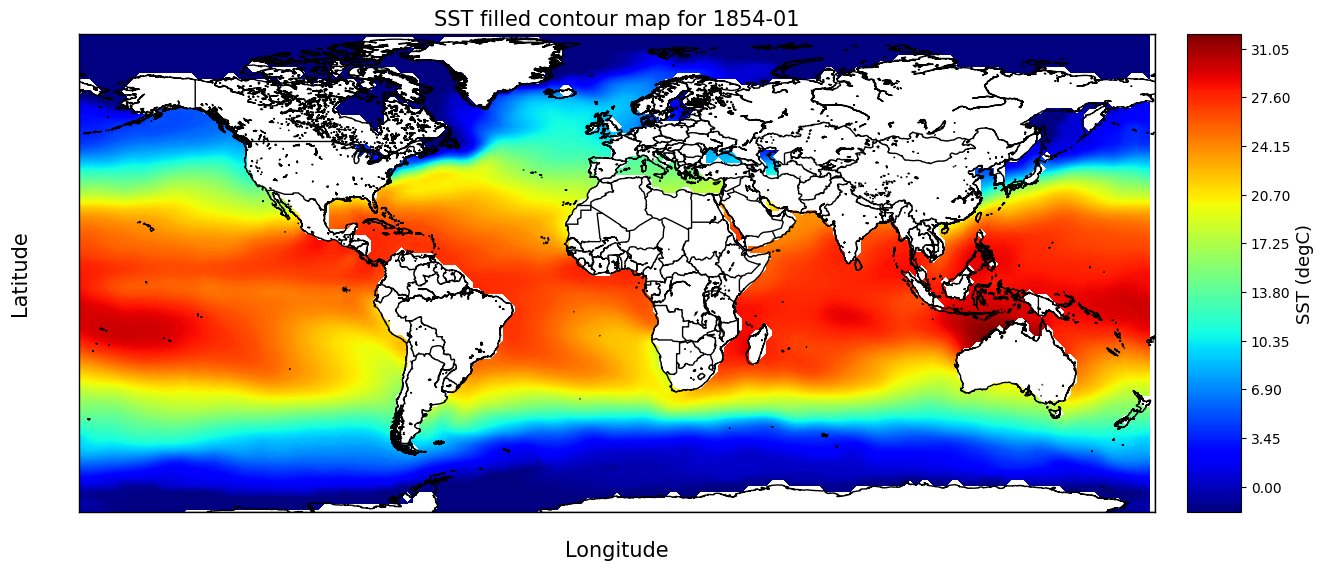

In [21]:
print_sst_map(ds, 0)

(89, 180)


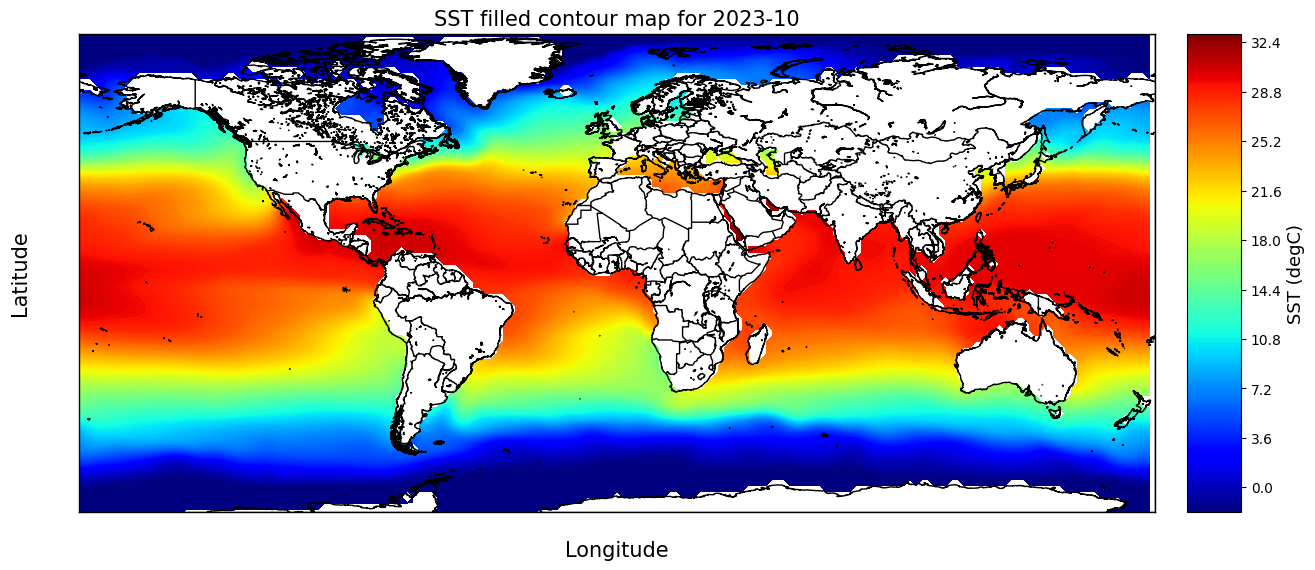

In [22]:
print_sst_map(ds, -1)

In [43]:
df.head()

,lat,lon,time,nbnds,time_bnds,sst
0,88.0,0.0,1854-01-01,0,9.969210e+36,-1.8
2,88.0,0.0,1854-02-01,0,9.969210e+36,-1.8
4,88.0,0.0,1854-03-01,0,9.969210e+36,-1.8
6,88.0,0.0,1854-04-01,0,9.969210e+36,-1.8
8,88.0,0.0,1854-05-01,0,9.969210e+36,-1.8


In [44]:
df['time']

0           1854-01-01
2           1854-02-01
4           1854-03-01
6           1854-04-01
8           1854-05-01
               ...    
65297510    2023-06-01
65297512    2023-07-01
65297514    2023-08-01
65297516    2023-09-01
65297518    2023-10-01
Name: time, Length: 32648760, dtype: object

In [25]:
print(np.max(df['sst']))
print(np.min(df['sst']))

42.32636
-1.8


# Definição de Funções úteis

In [181]:
class SSTUtil:
    """ SST Helper functions 

    Use the following date format: YYYY-MM-DD
    """

    def get_sst_series(df: pd.DataFrame, lat: int, lon: int):
        sst_series = df[(df['lat'] == lat) & (df['lon'] == lon)].reset_index(drop=True)
        sst_series.set_index('time', inplace=True)
        sst_series.drop(['lat', 'lon'], axis=1, inplace=True)
        return sst_series

    def get_subseries_by_index(df: pd.DataFrame, start_index: int, window: int):
        return df[start_index:start_index+window]

    def get_subseries_by_date(df: pd.DataFrame, start_date: str, window: int):
        return df.loc[start_date:][:window]

    def plot_sst(df: pd.DataFrame, start_date: int|str, window: int):
        fig, ax = plt.subplots()
        if isinstance(start_date, str):
            subseries = SSTUtil.get_subseries_by_date(df, start_date, window)
        elif isinstance(start_date, int):
            subseries = SSTUtil.get_subseries_by_index(df, start_date, window)
        ax.plot(subseries.index, subseries['sst'], linewidth=2.0)
        plt.xticks(rotation=30)
        plt.show()

    def split_train_test(df: pd.DataFrame, split_date: str):
        train = df.loc[:split_date]
        test = df.loc[split_date:][1:]
        return train, test

In [27]:
point_df = SSTUtil.get_sst_serie(df, 80, 40)
point_df

,lat,lon,time,nbnds,time_bnds,sst
0,80.0,40.0,1854-01-01,0,9.969210e+36,-1.800000
1,80.0,40.0,1854-02-01,0,9.969210e+36,-1.800000
2,80.0,40.0,1854-03-01,0,9.969210e+36,-1.800000
3,80.0,40.0,1854-04-01,0,9.969210e+36,-1.800000
4,80.0,40.0,1854-05-01,0,9.969210e+36,-1.800000
...,...,...,...,...,...,...
2033,80.0,40.0,2023-06-01,0,9.969210e+36,-0.377036
2034,80.0,40.0,2023-07-01,0,9.969210e+36,-0.337968
2035,80.0,40.0,2023-08-01,0,9.969210e+36,2.898502
2036,80.0,40.0,2023-09-01,0,9.969210e+36,2.445415


In [38]:
len(df)

32648760

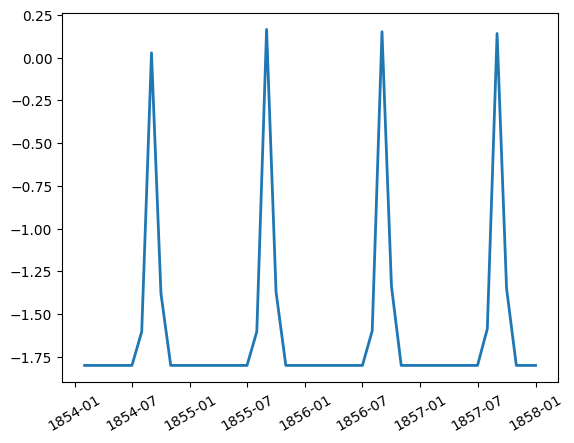

In [39]:
SSTUtil.plot_sst(point_df, 0, 48)

In [112]:
test_df = df[(df['lat'] == 80) & (df['lon'] == 40)].reset_index(drop=True).set_index('time')
test_df.drop(['lat', 'lon'], axis=1, inplace=True)
test_df.loc['1854-01-01']

nbnds        0.000000e+00
time_bnds    9.969210e+36
sst         -1.800000e+00
Name: 1854-01-01 00:00:00, dtype: float64

In [172]:
test_df.loc['2023-01-01':][:-1]

,nbnds,time_bnds,sst
time,,,
2023-01-01,0,9.969210e+36,-1.800000
2023-02-01,0,9.969210e+36,-1.800000
2023-03-01,0,9.969210e+36,-1.800000
2023-04-01,0,9.969210e+36,-1.800000
2023-05-01,0,9.969210e+36,-1.800000
2023-06-01,0,9.969210e+36,-0.377036
2023-07-01,0,9.969210e+36,-0.337968
2023-08-01,0,9.969210e+36,2.898502
2023-09-01,0,9.969210e+36,2.445415


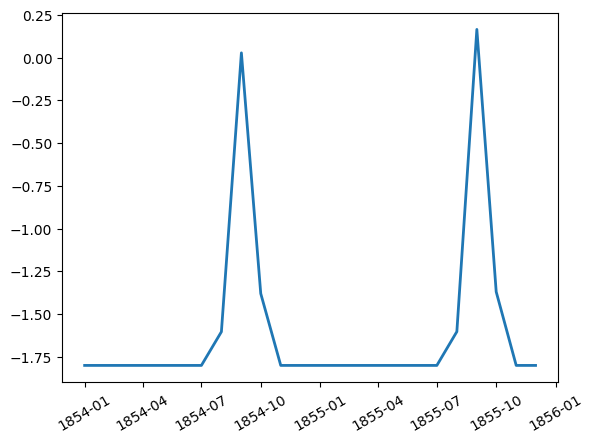

In [114]:
SSTUtil.plot_sst(test_df, 0, 24)

# SubserieDTW
A classe tem utilidades para pegar uma subsérie em um ponto e comparar com outras subséries no passado

In [192]:
class SubserieDTW:
    """ Use this class to process information before using SVR """

    lat: int
    lon: int
    train_proportion: int
    window: float
    df: pd.DataFrame
    list_subseries: list

    def __init__(self, df, lat, lon, split_date: str, window: int = 48, forecast_horizon: int = 1):
        print("Initializing")
        print(f"Lat: {lat}, Lon: {lon}")
        self.lat = lat
        self.lon = lon
        self.window = window
        self.forecast_horizon = forecast_horizon
        self.df = df

        self.point_df = SSTUtil.get_sst_series(df, lat, lon)
        self.df_len = len(point_df)

        #          Split into train/test
        # |---------train---------main-|---test---|      
        self.train_df, self.test_df = SSTUtil.split_train_test(self.point_df, split_date)
        # self.train_df = self.point_df[:start-window].reset_index(drop=True)
        # self.test_df = self.point_df[start+window:].reset_index(drop=True)
        
        # Get main subserie
        self.main_subserie = SSTUtil.get_subseries_by_index(self.train_df, len(self.train_df) - window, window)
        self.train_df = self.train_df[:-window]
        print(f"Total length: {self.df_len}")
        print(len(self.train_df), len(self.test_df))
        print(f"Train/test proportion: {len(self.train_df)/self.df_len}/{len(self.test_df)/self.df_len}")

    
    def get_nearest_subseries(self):
        list_subseries = []
        np_main_subserie = np.array(self.main_subserie['sst'])
        for i in tqdm(range(0, len(self.train_df) - (2*self.window))):
            subserie_df = SSTUtil.get_subseries_by_index(self.train_df, i, self.window)
            np_subserie = np.array(subserie_df['sst'])
            np_next_subserie = np.array(SSTUtil.get_subseries_by_index(self.train_df, i+self.window, self.forecast_horizon)['sst'])
            try:
                if len(np_main_subserie) == len(np_subserie):
                    alignment = dtw(np_main_subserie, np_subserie, keep_internals=True)
                    subserie = {
                        'df': np_subserie,
                        'start': i,
                        'distance': alignment.distance,
                        'alignment': alignment,
                        'next': np_next_subserie
                    }

                    list_subseries.append(subserie)
            except ValueError as e:
                print(f"Got value error: {e}")
        self.list_subseries = sorted(list_subseries, key=lambda item: item['distance'], reverse=False)
        print(f"Obtained {len(self.list_subseries)} subseries")
        return self.list_subseries
    
    def print_nearest_subserie(self):
        nearest = self.list_subseries[0]
        print(f"DTW Distance: {nearest['distance']}")
        nearest['alignment'].plot(type="twoway",offset=-2)

    def get_train(self, top_n_series: int = 200):
        x_train = [i['df'] for i in self.list_subseries[:top_n_series]]
        y_train = [i['next'] for i in self.list_subseries[:top_n_series]]
        return np.array(x_train), np.array(y_train)

    def get_test(self):
        x_test = []
        y_test = []
        for i in (range(0, 60)):
            x_test.append(np.array(SSTUtil.get_subseries_by_index(self.test_df, i, self.window)['sst']))
            y_test.append(np.array(SSTUtil.get_subseries_by_index(self.test_df, i+self.window, self.forecast_horizon)['sst']))
        return np.array(x_test), np.array(y_test)

    def get_point_df(self):
        return self.point_df
    

In [193]:
s = SubserieDTW(df, 80, 40, '1975-01-01')

Initializing
Lat: 80, Lon: 40
Total length: 2038
1405 585
Train/test proportion: 0.6894013738959764/0.28704612365063786


### Obtendo as séries mais próximas

In [194]:
nearest = s.get_nearest_subseries()

100%|██████████| 1309/1309 [00:01<00:00, 935.10it/s]

Obtained 1309 subseries


fig, ax = plt.subplots()
ax.plot(point_df[''], y, linewidth=2.0)
plt.show()
plt.plot(point_df['sst'])

### Plotando Subséries mais próximas

DTW Distance: 8.87157392501831


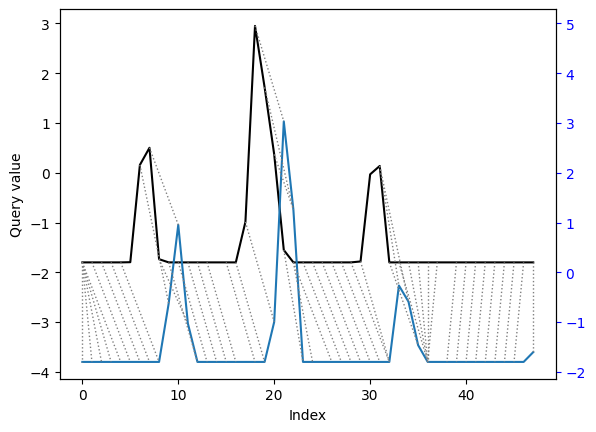

In [195]:
s.print_nearest_subserie()

### Plotando Subséries mais distantes

22.981073021888733


<Axes: xlabel='Index', ylabel='Query value'>

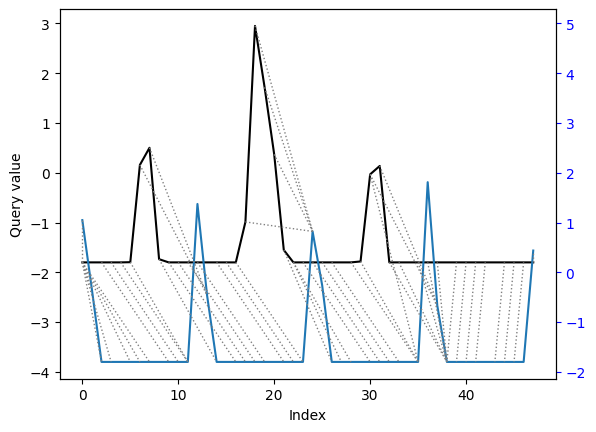

In [196]:
print(nearest[-1]['distance'])
nearest[-1]['alignment'].plot(type="twoway",offset=-2)

## Obtendo 5 pontos no mar
* Um ponto na região do ENSO;
 -> lat = 20°, lon = -132° (https://www.google.com.br/maps/place/20%C2%B000'00.0%22N+132%C2%B000'00.0%22W/@22.1775213,-151.1364928,3.87z/data=!4m4!3m3!8m2!3d20!4d-132?entry=ttu)

* Um ponto na costa do Chile (Corrente de Humboldt);
 -> lat = -22°, lon = -72° (https://www.google.com.br/maps/place/22%C2%B000'00.0%22S+72%C2%B000'00.0%22W/@-21.7898533,-87.474343,4.04z/data=!4m4!3m3!8m2!3d-22!4d-72?entry=ttu)

* Um ponto no meio do Mediterrâneo;
 -> lat = 36°, lon = 18° (https://www.google.com.br/maps/place/36%C2%B000'00.0%22N+18%C2%B000'00.0%22E/@36.0000043,17.9974251,17z/data=!3m1!4b1!4m4!3m3!8m2!3d36!4d18?entry=ttu)

* Um ponto no meio do Atlântico;
 -> lat = 0°, lon = -22° (https://www.google.com.br/maps/place/0%C2%B000'00.0%22N+22%C2%B000'00.0%22W/@-11.0144452,-50.6148726,3z/data=!4m3!3m2!8m1!4d-22?entry=ttu)

* Um ponto no extremo Índico (ponto de maior latitude, temperaturas mais baixas)
 -> lat = -56°, lon = 80° (https://www.google.com.br/maps/place/56%C2%B000'00.0%22S+80%C2%B000'00.0%22E/@-36.027701,54.6888129,3z/data=!4m4!3m3!8m2!3d-56!4d80?entry=ttu)

In [197]:
# enso = SubserieDTW(df, 20, f_inv(-132), 1500, 48)
split_date = '2000-01-01'

chil = SubserieDTW(df, -22, f_inv(-72), split_date=split_date)
medi = SubserieDTW(df, 36, f_inv(18), split_date=split_date)
atla = SubserieDTW(df, 0, f_inv(-2), split_date=split_date)

indi = SubserieDTW(df, -56, f_inv(-80), split_date=split_date)


Initializing
Lat: -22, Lon: 108
Total length: 2038
1705 285
Train/test proportion: 0.8366045142296369/0.13984298331697742
Initializing
Lat: 36, Lon: 198
Total length: 2038
1705 285
Train/test proportion: 0.8366045142296369/0.13984298331697742
Initializing
Lat: 0, Lon: 178
Total length: 2038
1705 285
Train/test proportion: 0.8366045142296369/0.13984298331697742
Initializing
Lat: -56, Lon: 100
Total length: 2038
1705 285
Train/test proportion: 0.8366045142296369/0.13984298331697742


100%|██████████| 1609/1609 [00:01<00:00, 843.13it/s] 


Obtained 1609 subseries
DTW Distance: 10.997442591935396


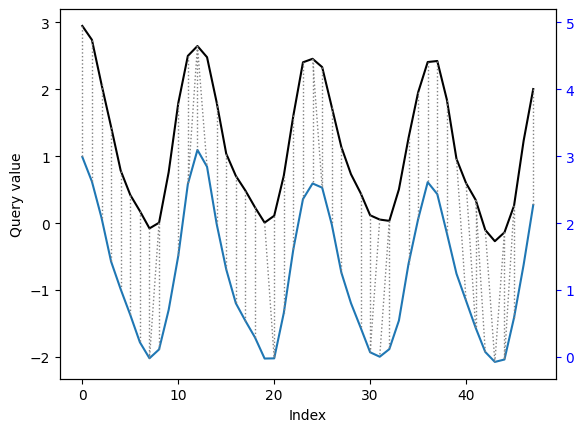

In [198]:
indi.get_nearest_subseries()
indi.print_nearest_subserie()

# Support Vector Regressor (SVR)
Vamos pegar as séries mais próximas da série atual e treinar um SVR para predizer os próximos passos 

In [199]:
x_train, y_train = indi.get_train(-1)
x_test, y_test = indi.get_test()

In [200]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1608, 48) (1608, 1)
(60, 48) (60, 1)


In [201]:
from sklearn.linear_model import SGDRegressor
model = SGDRegressor()

In [202]:
print(len(x_train), len(y_train))
model.fit(x_train, y_train)

1608 1608


/home/vitor/Documents/sst-time-series-ml/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor()

In [203]:
y_train_pred = model.predict(x_train).reshape(-1, 1)
y_test_pred = model.predict(x_test).reshape(-1, 1)

print(y_train_pred.shape, y_test_pred.shape)

(1608, 1) (60, 1)


### Treino

In [204]:
model.score(x_train, y_train)

0.9680202119687682

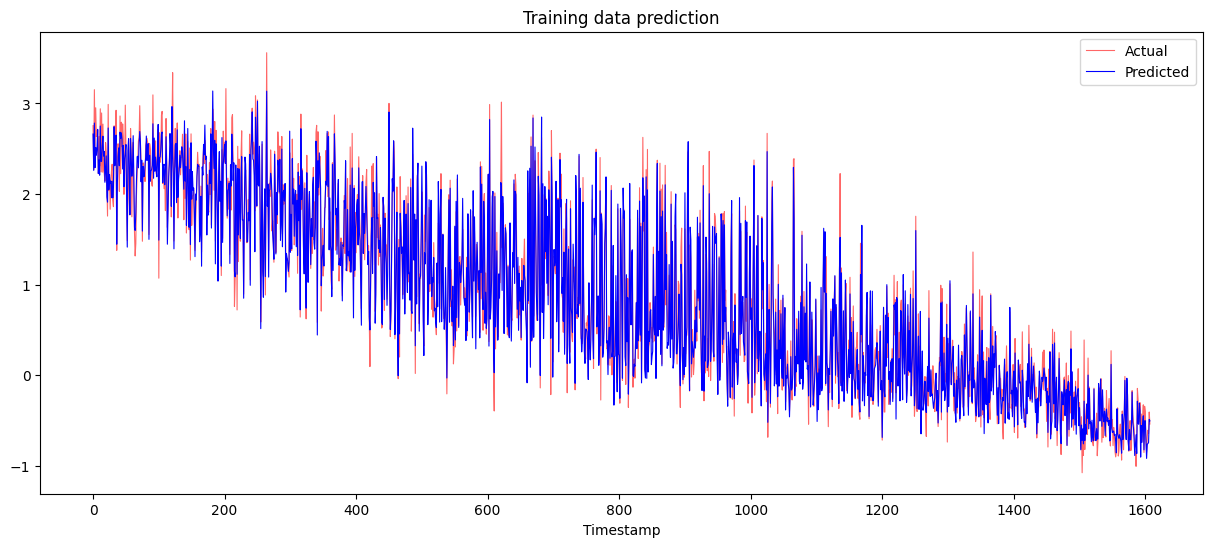

In [205]:
plt.figure(figsize=(15,6))
plt.plot(range(len(y_train)), y_train, color = 'red', linewidth=.8, alpha = 0.6)
plt.plot(range(len(y_train_pred)), y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

### Teste

In [206]:
model.score(x_test, y_test)

0.9757140325705658

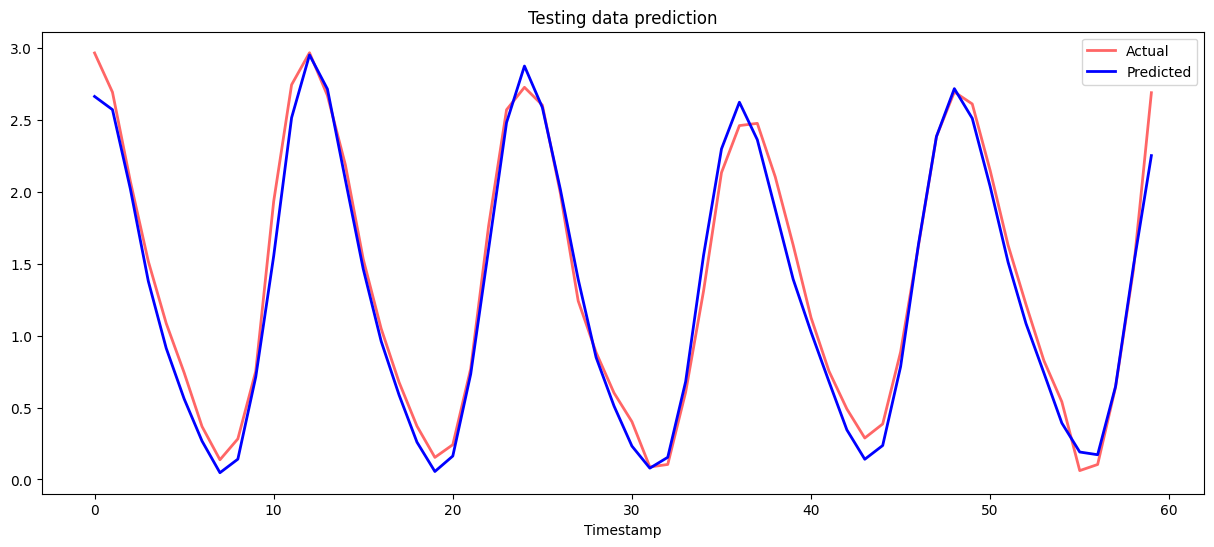

In [207]:
plt.figure(figsize=(15,6))
plt.plot(range(len(y_test)), y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(range(len(y_test_pred)), y_test_pred, color = 'blue', linewidth=2.0)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Testing data prediction")
plt.show()

### Analisando o Erro
Como o erro se comporta nesse caso?

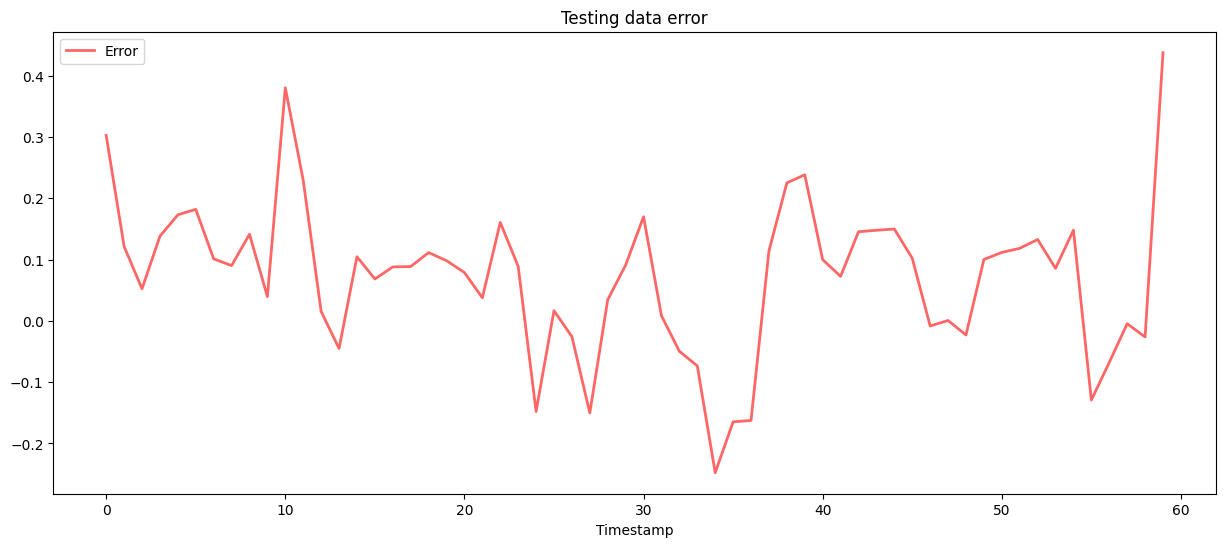

In [208]:
plt.figure(figsize=(15,6))
plt.plot(range(len(y_test)), y_test - y_test_pred, color = 'red', linewidth=2.0, alpha = 0.6)
plt.legend(['Error'])
plt.xlabel('Timestamp')
plt.title("Testing data error")
plt.show()

### Previsão dos próximos $n$ meses

In [80]:
recent_x, _ = indi.get_test()
original_recent_x = recent_x.copy()
prediction_range = 60
y_pred = [recent_x[0][-1]]
print(y_pred)

for i in range(prediction_range):
    new_pred = model.predict(recent_x[0][-48:].reshape(1, -1))
    y_pred.append(new_pred[0])
    recent_x = np.append(recent_x[0], new_pred).reshape(1, -1)
print(y_pred)

[0.91685045]
[0.91685045, 1.7335384152265876, 2.6151412882540566, 2.9759383876058747, 2.6862882570990485, 2.005312232766051, 1.2905290426532647, 0.7674711749571004, 0.4083197147071088, 0.10299401900218544, -0.10652240080468267, -0.007727274692087192, 0.5856294790543941, 1.5368455760489583, 2.418561460713213, 2.788459374226601, 2.525129040444245, 1.8662562933825082, 1.183122340315752, 0.6922254528265303, 0.34049267816906903, 0.03497974520011135, -0.16562679754169318, -0.06256616131753032, 0.5057964330142082, 1.4726099800144143, 2.3854271331289243, 2.789858560000888, 2.5412697023950526, 1.8659334408349062, 1.156569434906405, 0.6280876619409057, 0.26896512780956294, -0.02937289366996089, -0.22304593702489617, -0.11033058267706253, 0.46803612139068895, 1.4155056671697805, 2.3153486573521227, 2.740960503463369, 2.5324367971139488, 1.8887002669395043, 1.1694546580618237, 0.6130024477052859, 0.22361874212549948, -0.08525539894094669, -0.29020971697213926, -0.1719550334391486, 0.42716396707220

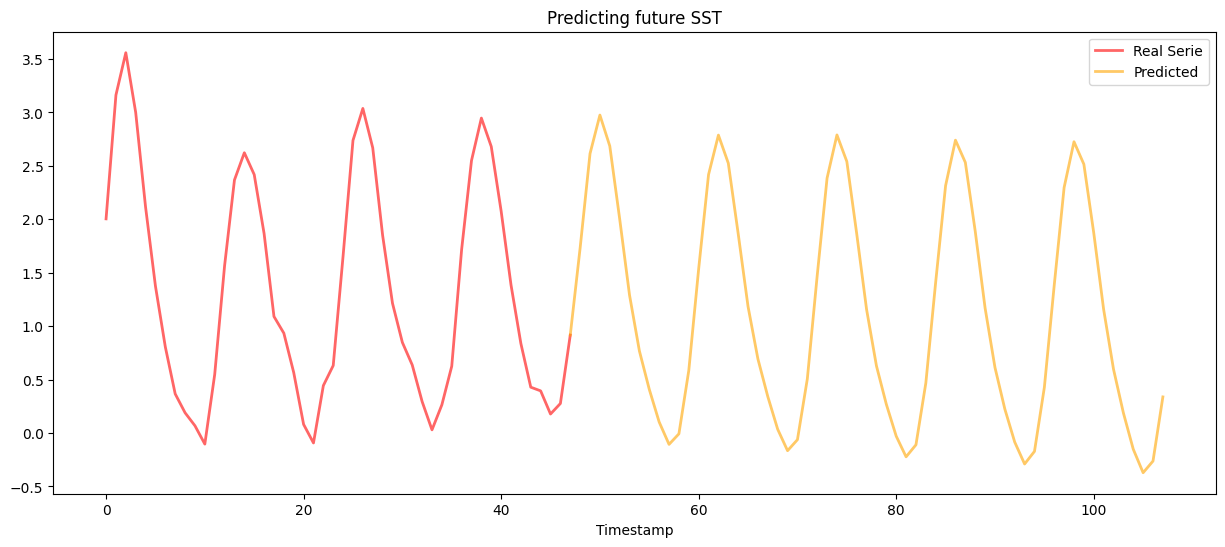

In [81]:
plt.figure(figsize=(15,6))
plt.plot(range(0, 48), original_recent_x[0][-48:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(range(47, prediction_range+48), y_pred, color = 'orange', linewidth=2.0, alpha = 0.6)

plt.legend(['Real Serie', 'Predicted'])
plt.xlabel('Timestamp')
plt.title("Predicting future SST")
plt.show()

### Entendendo a relação *número de séries mais próximas utilizadas* VS *score*

In [82]:
n_nearest_series_list = []
score = []
len_train = len(y_train)

model = SGDRegressor(verbose=False)
for i in tqdm(range(1, len_train, 15)):
    x_train, y_train = indi.get_train(i)
    x_test, y_test = indi.get_test()


    model.fit(x_train, y_train)

    n_nearest_series_list.append(i)
    score.append(model.score(x_test, y_test))

  0%|          | 0/86 [00:00<?, ?it/s]/home/vitor/Documents/sst-time-series-ml/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  1%|          | 1/86 [00:00<00:09,  8.85it/s]/home/vitor/Documents/sst-time-series-ml/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  2%|▏         | 2/86 [00:00<00:09,  8.53it/s]/home/vitor/Documents/sst-time-series-ml/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

In [83]:
value = np.mean(score)
ideal_n_nearest = 0

for i in range(len(score)):
    if abs(score[i] - value) <= 0.01:
        ideal_n_nearest = n_nearest_series_list[i]
        break


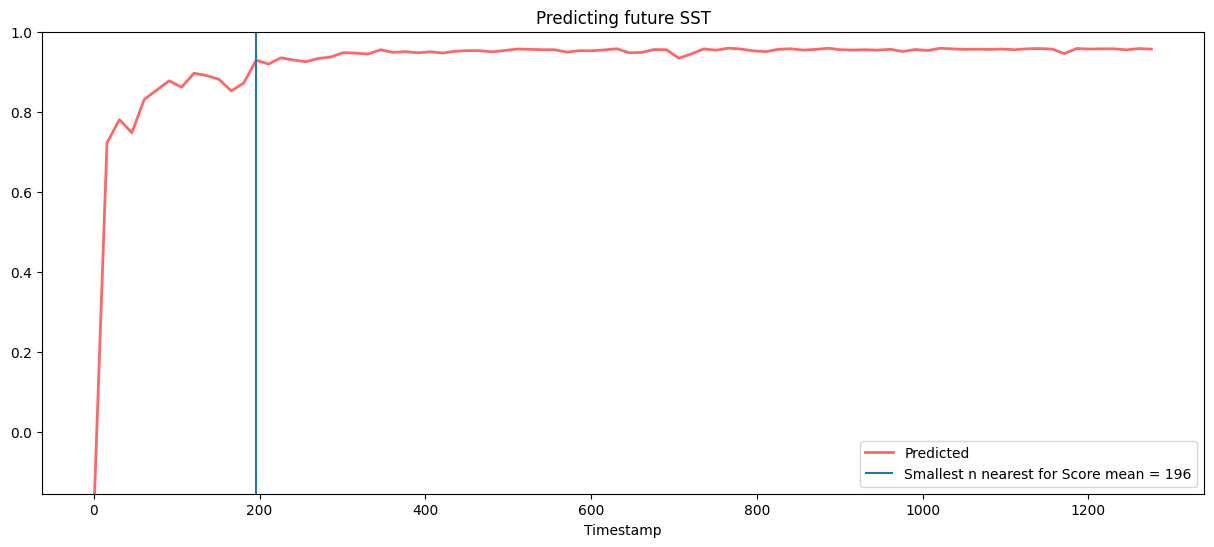

In [84]:
plt.figure(figsize=(15,6))
plt.plot(n_nearest_series_list, score, color = 'red', linewidth=2.0, alpha = 0.6, )
plt.vlines(ideal_n_nearest, np.min(score), 1)
plt.ylim(np.min(score), 1)
plt.legend(['Predicted', f'Smallest n nearest for Score mean = {ideal_n_nearest}'])
plt.xlabel('Timestamp')
plt.title("Predicting future SST")
plt.show()

In [86]:
ideal_n_nearest / len_train

0.15300546448087432

### Vector Regression
Agora vamos treinar diversos SVR para predizer dias a frente

In [129]:
forecast_horizon = 48

In [130]:
from sklearn.multioutput import MultiOutputRegressor

In [131]:
indi = SubserieDTW(df, -56, f_inv(-80), 0.7, 48, forecast_horizon)
indi.get_nearest_subseries()

Initializing
Lat: -56, Lon: 100
Total length: 2038
Train/test proportion: 0.676153091265947/0.27674190382728164


  0%|          | 0/1282 [00:00<?, ?it/s]

100%|██████████| 1282/1282 [00:03<00:00, 412.37it/s]


Obtained 1282 subseries


[{'df': array([ 1.4236748 ,  2.1232882 ,  2.335143  ,  2.4088223 ,  2.309516  ,
          1.5767584 ,  0.9961697 ,  0.29591137, -0.10476413, -0.17430435,
         -0.17937902, -0.27327693,  0.80333364,  2.0616462 ,  2.662794  ,
          2.4394486 ,  1.5640371 ,  1.1225648 ,  0.4424461 ,  0.21743676,
          0.14165932, -0.15833105, -0.2729783 ,  0.36512154,  1.4920138 ,
          2.208566  ,  2.571698  ,  2.1183395 ,  1.5704423 ,  0.9268481 ,
          0.4541263 ,  0.03535253, -0.19182271, -0.36731607, -0.10937667,
          0.7391279 ,  1.4518595 ,  2.214198  ,  2.7028596 ,  2.472563  ,
          1.7415092 ,  1.1123681 ,  0.68184936,  0.3788892 ,  0.23761222,
         -0.0866574 ,  0.23325492,  0.569689  ], dtype=float32),
  'start': 1054,
  'distance': 13.837119415402412,
  'alignment': DTW alignment object of size (query x reference): 48 x 48,
  'next': array([ 1.4144597 ,  2.2417483 ,  2.572718  ,  2.6148434 ,  1.7472829 ,
          0.88567084,  0.56852615,  0.514891  ,  0.16376

In [132]:
x_train, y_train = indi.get_train(-1)
x_test, y_test = indi.get_test()

In [133]:
x_train.shape, y_train.shape

((1281, 48), (1281, 48))

In [134]:
multi_model = MultiOutputRegressor(SGDRegressor())
multi_model.fit(x_train, y_train)

MultiOutputRegressor(estimator=SGDRegressor())

In [135]:
multi_model.score(x_test, y_test)

0.9225024551535871

In [136]:
y_pred = multi_model.predict([x_test[-1]])

In [137]:
y_pred

array([[0.49291916, 1.41917684, 2.39753975, 2.73543009, 2.50618541,
        1.84591314, 1.20032881, 0.84621744, 0.61377731, 0.41020471,
        0.08925035, 0.01485725, 0.55889021, 1.5150701 , 2.34118367,
        2.75609104, 2.43394906, 1.74024627, 1.14518659, 0.74066186,
        0.62371026, 0.41003969, 0.10798379, 0.16310671, 0.63527284,
        1.50194041, 2.2040423 , 2.61041625, 2.42349367, 1.81779271,
        1.06387111, 0.7434427 , 0.57076582, 0.35377142, 0.05682984,
        0.00869563, 0.51685188, 1.37041383, 2.2063675 , 2.70366069,
        2.48735863, 1.9370785 , 1.20746257, 0.934807  , 0.56322241,
        0.48747248, 0.22978784, 0.15751429]])

In [138]:
original_recent_x = x_test[-1]

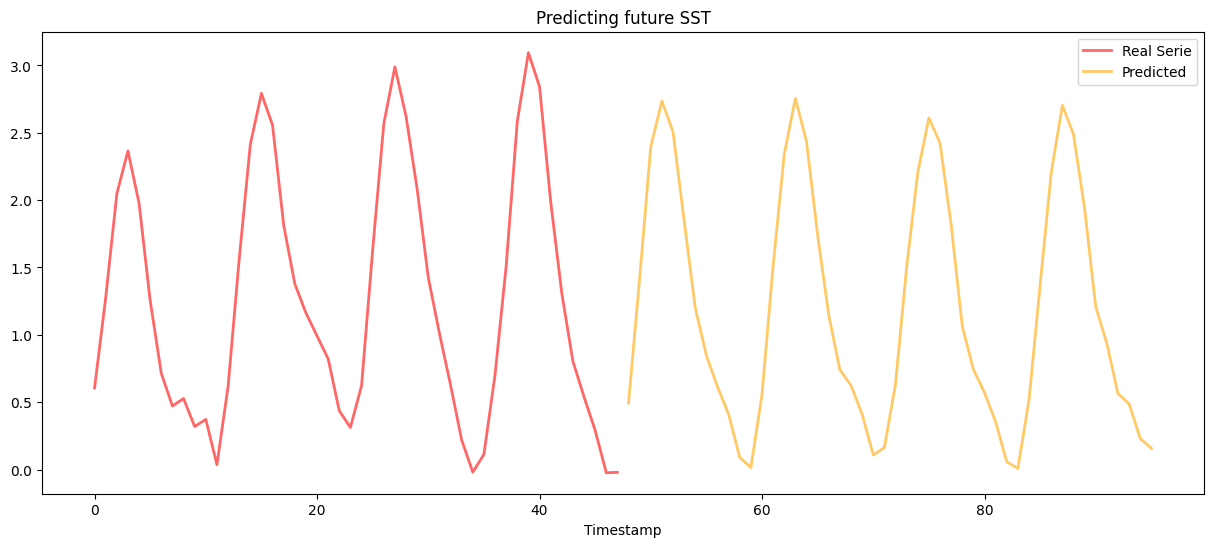

In [139]:
plt.figure(figsize=(15,6))
plt.plot(range(0, 48), original_recent_x[-48:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(range(48, forecast_horizon+48), y_pred[0], color = 'orange', linewidth=2.0, alpha = 0.6)

plt.legend(['Real Serie', 'Predicted'])
plt.xlabel('Timestamp')
plt.title("Predicting future SST")
plt.show()

Ao invés de treinar o modelo as 1171 séries mais próximas, podemos utilizar apenas 181, que representa 15% do conjunto de treinamento total para obter 95% de acurácia

## Comparação com outras séries temporais

Vamos comparar a série do oceano índico com outras séries

In [ ]:
indi_df = indi.get_point_df()['sst']
indi_df.head()

0    1.944521
1    2.395283
2    2.233423
3    1.863559
4    1.310429
Name: sst, dtype: float32

81726.33189344406


<Axes: xlabel='Index', ylabel='Query value'>

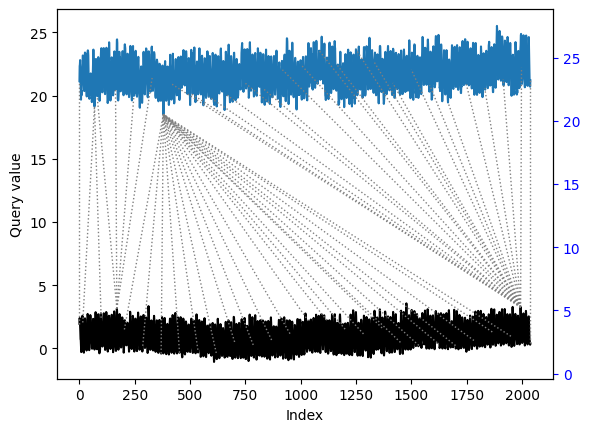

In [ ]:
chil_df = chil.get_point_df()['sst']
alignment_chil_df = dtw(indi_df, chil_df, keep_internals=True)
print(alignment_chil_df.distance)
alignment_chil_df.plot(type="twoway",offset=-2)

# medi_df = medi.get_point_df()['sst']
# alignment_medi_df = dtw(indi_df, medi_df, keep_internals=True)
# print(alignment_medi_df.distance)
# alignment_medi_df.plot(type="twoway",offset=-2)

# atla_df = atla.get_point_df()['sst']
# alignment_atla_df = dtw(indi_df, atla_df, keep_internals=True)
# print(alignment_atla_df.distance)
# alignment_atla_df.plot(type="twoway",offset=-2)


Podemos observar que o DTW não foi muito bom para comparar as séries já que houve grande dispersão dos dados